100%|██████████| 2/2 [00:00<00:00, 33.34it/s]


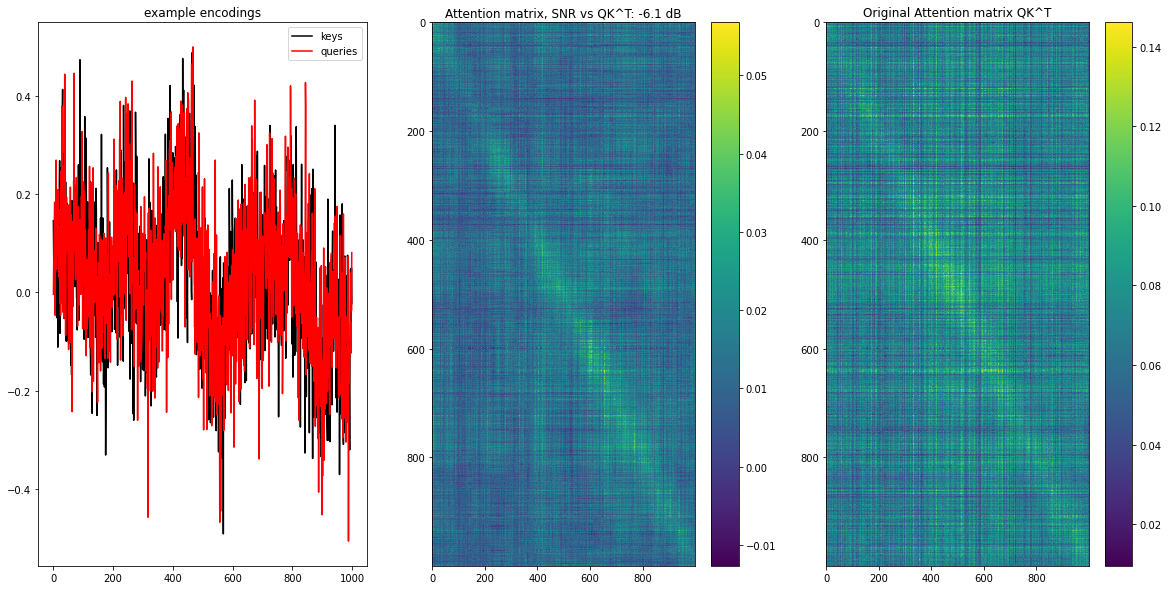

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import math
import spe
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import rfft, irfft
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# sine or conv
conv = True

# number of layers to simulate
n_layers = 2

# dimension for the keys and queries
keys_dim = 64
num_heads = 8
num_realizations = keys_dim
num_sines = 1
kernel_size = 100

# create the positional encoder, with a specified max lag
if conv:
    poscoder = spe.ConvSPE(ndim=1, in_features=keys_dim, kernel_size=kernel_size, num_heads=num_heads, num_realizations=num_realizations)
else:
    poscoder = spe.SineSPE(num_heads=num_heads, in_features=keys_dim, num_sines=num_sines, num_realizations=num_realizations)
poscoder.to(device=device)

filters = []
for layer in range(n_layers):
    filters += [spe.SPEFilter(gated=True, code_shape=poscoder.code_shape).to(device)]
    #filters[-1].gate.data[...] = -layer*5.
n = 1000
batchsize=8


# generate some encodings of shape (batchsize, num, n)
q = torch.rand(batchsize, n, num_heads, keys_dim, device=device, requires_grad=True)
k = torch.rand(batchsize, n, num_heads, keys_dim, device=device, requires_grad=True)


from tqdm import tqdm

loss = 0
poscode = poscoder(q)
for iteration in tqdm(range(n_layers)):
    # compute the attention matrix
    A0 = torch.mm(q[0,:,0,:], k[0,:,0,:].T) / keys_dim

    # apply SPE
    q, k = filters[iteration](q,k, poscode)

    # compute corresponding attention matrix
    A = torch.mm(q[0,:,0,:], k[0,:,0,:].T) / num_realizations

    # compute a loss to check backward
    loss = loss + A.sum()

# display some queries and keys
q = q.detach()
k = k.detach()

plt.figure(figsize=[20,10]);
plt.subplot(131)
plt.plot(k[0,:,0,0].cpu(),'k');
plt.plot(q[0,:,0,0].cpu(),'r');
plt.title('example encodings');
plt.legend(['keys', 'queries']);

# display the average dot product
plt.subplot(132);
plt.imshow(A.detach().cpu().numpy(), aspect='auto', interpolation='nearest');
plt.title('Attention matrix, SNR vs QK^T: %0.1f dB'%(10*torch.log10(A.norm()/(A-A0).norm())));
plt.colorbar();

plt.subplot(133);
plt.imshow(A0.detach().cpu().numpy(), aspect='auto', interpolation='nearest');
plt.title('Original Attention matrix QK^T');
plt.colorbar();
